# PINN model of forces and torques in particle-laden flows

## Initializations

### Package imports

In [9]:
# Initializations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
tf.get_logger().setLevel('ERROR')

%config InlineBackend.figure_formats = ['svg']
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.family':'serif'})
mpl.rcParams.update({'font.serif':'STIXGeneral'})
mpl.rcParams.update({'axes.titlesize':18})
mpl.rcParams.update({'axes.labelsize': 20})
mpl.rcParams.update({'axes.labelpad':12})
mpl.rcParams.update({'axes.linewidth': 0.5})
mpl.rcParams.update({'xtick.labelsize': 12})
mpl.rcParams.update({'ytick.labelsize': 12})

### Regression plot function

In [58]:
def plot_regression(D_in, D_pred, coord=None, title=None, save_fig=False, img_name='regression.png'):
    
    # generate the best fit for the predicted data ___________________
    lim1 = np.mean(D_in) - 3.5*np.std(D_in)
    lim2 = np.mean(D_in) + 3.5*np.std(D_in)
    lim3 = np.mean(D_pred) - 2*np.std(D_pred)
    
    # Plots _____________________
    fig, ax1 = plt.subplots(figsize=(4,4), tight_layout=True)
    
    ax1.scatter(D_in, D_pred,
                marker='o',
                s=9, linewidth=0.5,
                alpha=0.8,
                edgecolor='tab:blue', facecolor='white')
    ax1.plot([lim1, lim2], [lim1, lim2], linestyle='--', color='red', linewidth=2, alpha=0.8)
    
    ax1.set_aspect('equal')
    
    if coord != None:
        if coord == 'F_x':
            ax1.set_xlabel('$\Delta F_{x,DNS}$', labelpad=15)
            ax1.set_ylabel('$\Delta F_{x,PINN}$', labelpad=10)
        elif coord == 'F_L':
            ax1.set_xlabel('$\Delta F_{L,DNS}$', labelpad=15)
            ax1.set_ylabel('$\Delta F_{L,PINN}$', labelpad=10)
        elif coord == 'T_L':
            ax1.set_xlabel('$\Delta T_{L,DNS}$', labelpad=15)
            ax1.set_ylabel('$\Delta T_{L,PINN}$', labelpad=10)
    
    ax1.set_xlim((1.0*lim1, 1.0*lim2))
    ax1.set_ylim((1.0*lim1, 1.0*lim2))

    #     ax1.set_xticks(range(-4,5,1))
    #     ax1.set_yticks(range(-4,5,1))

    # R^2 on plot _____________________
    x_ann = ax1.get_xlim()[1] - 0.05*(plt.xlim()[1]-plt.xlim()[0])
    y_ann = ax1.get_ylim()[0] + 0.05*(plt.ylim()[1]-plt.ylim()[0])
    ax1.annotate(str(r'$ R^2 = ' + f'{r2_score(D_in, D_pred):.2f} $'), 
                 xy=(x_ann, y_ann),
                 horizontalalignment='right',
                 verticalalignment='bottom',
                 fontsize=18);

    # Set the font name for axis tick labels _____________________
    for tick in ax1.get_xticklabels():
        tick.set_fontname('STIXGeneral')
    for tick in ax1.get_yticklabels():
        tick.set_fontname('STIXGeneral')

    # ticks _____________________
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)
    
    ax1.xaxis.set_major_locator(MaxNLocator(5))
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax1.yaxis.set_major_locator(MaxNLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax1.tick_params(which='major', length=5)
    ax1.tick_params(which='minor', length=2)
        
    if title != None:
        ax1.set_title(title)

    fig.patch.set_facecolor('white')
        
    if save_fig:
        fig.savefig(img_name, bbox_inches='tight')

### Data augmentation function

In [18]:
def data_augment(X, n):

    X_rot = np.zeros((0, X.shape[1]))
    θ_vec = np.linspace(0, 2*np.pi, n)[1:-1]

    for θ in θ_vec:

        X_tmp = np.zeros(X.shape)

        for i in range(0, X.shape[1], 3):
            X_tmp[:, i] = X[:, i]

        for i in range(1, X.shape[1], 3):
            X_tmp[:, i] = X[:, i+1] * np.sin(θ) + X[:, i] * np.cos(θ)
        
        for i in range(2, X.shape[1], 3):
            X_tmp[:, i] = X[:, i] * np.cos(θ) - X[:, i-1] * np.sin(θ)

        X_rot = np.vstack((X_rot, X_tmp))

    return X_rot

### Function for visualizing the output of fully-connected layers

In [57]:
def plot_NN(model, n_rot=1, save_fig=False):

    layer_name = 'p_shared2'  # name of the final NN layer
    intermediate_layer_model = Model(inputs=model.get_layer(f'p_r0').output,
                                    outputs=model.get_layer(layer_name).output)

    p = num_p_incl - 1
    R = np.sqrt( (X_in[:, 3*p:3*p+3]**2).sum(axis=1) )
    R_max = R.max()
    print(f'Max neighbor distance = {R_max:.3f}')

    lim = R_max + 0.5
    grid_n = 100
    x_range = np.linspace(-lim, lim, grid_n)
    y_range = np.linspace(-lim, lim, grid_n)

    xx, yy = np.meshgrid(x_range, y_range)

    # averagin in the azimuthal direction over several planes_____________
    θ_vec = np.linspace(0, 2 * np.pi, n_rot)
    D_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))

    for i in range(len(θ_vec)):
        θ = θ_vec[i]
        p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.sin(θ) + yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.cos(θ) - yy * np.sin(θ)).reshape(-1, 1)
                            ))

        D_tmp = intermediate_layer_model.predict(p_positions).sum(axis=1)
        D_pred[i, :, :] = D_tmp.reshape(xx.shape)

    D_pred = D_pred.mean(axis=0)

    # ploting___________________________________________
    fig, ax1 = plt.subplots(figsize=(4, 3), tight_layout=True)

    a = 0.2 * max(abs(D_pred.min()), abs(D_pred.max()))

    contour = ax1.contourf(xx, yy, D_pred,
                        cmap='jet',
                        levels=np.linspace(-a, a, 100),
                        extend='both')

    circ1 = plt.Circle((0, 0),
                       radius=0.5,
                        alpha=1,
                        facecolor='black',
                        edgecolor='black',
                        linewidth=2,
                        zorder=2)
    circ2 = plt.Circle((0, 0),
                       radius=1,
                        alpha=1,
                        facecolor='white',
                        edgecolor='black',
                        linewidth=1,
                        zorder=1)
    circ_max = plt.Circle((0, 0),
                        radius=R_max,
                        alpha=1,
                        facecolor='none',
                        edgecolor='white',
                        linewidth=1,
                        linestyle='--',
                        zorder=1)
    ax1.add_patch(circ1)
    ax1.add_patch(circ2)
    ax1.add_patch(circ_max)
    ax1.set_aspect('equal')

    ax1.set_title(r'$ \Delta ' + f'{coord}, ' + r'(Re, \phi) = (' + f'{Re}, {phi})' + r'$',
                  fontsize=14)

    ax1.set_xlabel('$ r_x $', labelpad=0)
    # ax1.set_ylabel('$ r_L $', labelpad=0)

    from matplotlib.ticker import MaxNLocator
    ax1.xaxis.set_major_locator(MaxNLocator(5))
    ax1.yaxis.set_major_locator(MaxNLocator(5))

    # colorbar________________________
    from matplotlib.ticker import StrMethodFormatter
    cb = fig.colorbar(contour,  format=StrMethodFormatter('{x:g}'), extendrect=True)
    cb.ax.tick_params(labelsize=12)

    # remove white lines separating the contours_______________
    for c in contour.collections:
        c.set_edgecolor('face')

    # Adjust number of ticks in colorbar
    cb.locator = MaxNLocator(nbins=6)
    cb.update_ticks()

    if save_fig:
        fig.savefig(f'NN_out_{coord}_Re{Re}_phi{phi.replace(".","")}.pdf', bbox_inches='tight')

## Fully-connected NN

<IPython.core.display.Math object>

Input shape: (3055, 90)
# of neighbors in the dataset = 30
# of neighbors used for training = 4
________________________________________
Training R^2	= 0.43
Test R^2	= 0.18

Training R^2	= 0.43
Test R^2	= 0.21

Training R^2	= 0.42
Test R^2	= 0.25

Training R^2	= 0.39
Test R^2	= 0.23

Training R^2	= 0.43
Test R^2	= 0.19

Overall performance:
<Training R^2> = 0.42
<Test R^2> = 0.21

Total number of model parameters: 283



<Figure size 432x288 with 0 Axes>

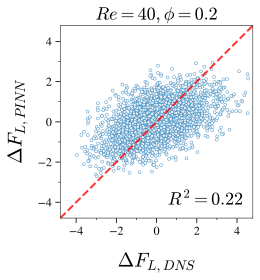

In [42]:
%reset -f array
%matplotlib inline

# free up memory from previous plots_________________
plt.close('all')
plt.clf()

# load dataset _______________________________________
Re = '40'
phi = '0.2'

num_p_incl = 4
N_neurons = 10
epochs = 1000
lr = 8e-3
verbose = 0
batch_size = 100

coord, title = 'F_L', r'$ Re = ' + f'{Re},' + r' \phi = ' + f'{phi} $'

dataset = pd.read_csv(f'./dataset/Re{Re}_phi{phi.replace(".","")}',
                        header=None, delim_whitespace=True).values

X_in = dataset[:, :-6]
Y_in = dataset[:, [-3]]
Y_in -= Y_in.mean()

from IPython.display import display, Math
display(Math(title))

print('Input shape:', X_in.shape)
print(f'# of neighbors in the dataset = {int((X_in.shape[1] - 3) / 3) + 1}')
print(f'# of neighbors used for training = {num_p_incl}')
print('________________________________________')

# Including a limited number of neighbors + V_in:
X_in = np.hstack((X_in[:, :3*(num_p_incl)], X_in[:, -3:]))

kf = KFold(n_splits=5, shuffle=True)
train_scores = []
test_scores = []

X_test_plot = np.zeros((0, X_in.shape[1]))
Y_test_plot = np.zeros((0, Y_in.shape[1]))
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))

# Train-Test split for K-fold cross-validation _______________________________________
for train_index, test_index in kf.split(X_in):
    
    X_train_list = []
    X_test_list = []
    p_input_list = []
    p_out_list = []
    
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    V_in_train, V_in_test = X_train[:, -3:], X_test[:, -3:]

    # Training =======================================
    
    # neural network _______________________________________
    r_input = Input(shape=X_train.shape[1], name='r_in')
    V_input = Input(shape=V_in_train.shape[1], name='V_in')

    layer = Dense(N_neurons, activation='tanh', name='layer_1')(r_input)
    layer = Dense(N_neurons, activation='tanh', name='layer_2')(layer)
    # layer = Dense(N_neurons, activation='tanh', name='layer_3')(layer)
    # layer = Dense(N_neurons, activation='tanh', name='layer_4')(layer)

    concat = Concatenate()([layer] + [V_input])
    
    output_layer = Dense(1,
                        activation='linear',
                        name='out_x',
                        use_bias=False)(concat)
    
    # Neural net fitting _______________________________________

    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / (SS_tot + K.epsilon())
    
    model = Model(inputs=[r_input] + [V_input],
                outputs=output_layer)

    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    mycallback = EarlyStopping(monitor='val_loss', patience=50)

    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)

    history = model.fit(
                        [X_train] + [V_in_train],
                        Y_train,

                        validation_split=0.2,
                        shuffle=True,
                        epochs=epochs,
                        verbose=verbose,
                        batch_size=batch_size,
                        callbacks=[mycallback],
                        )
    
    Y_pred = model.predict([X_train] + [V_in_train])
    
    print(f'Training R^2\t= {r2_score(Y_train, Y_pred):.2f}')
    train_scores.append(r2_score(Y_train, Y_pred))
    
    # Testing =======================================
    Y_pred_test = model.predict([X_test] + [V_in_test])
    
    print(f'Test R^2\t= {r2_score(Y_test, Y_pred_test):.2f}\n')
    test_scores.append(r2_score(Y_test, Y_pred_test))
    
    # dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))

print('========================================\nOverall performance:')
print(f'<Training R^2> = {np.mean(train_scores):.2f}')
print(f'<Test R^2> = {np.mean(test_scores):.2f}')

plot_regression(
    D_in=Y_test_plot,
    D_pred=Y_pred_test_plot,
    coord=coord, title=title,
    save_fig=False, img_name=f'corr_{coord}_Re{Re}_phi{phi.replace(".","")}.pdf')

# # plot_model(model, to_file='architecture.png', rankdir='LR')
print(f'\nTotal number of model parameters: {model.count_params()}\n')

## PINN Drag

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Input shape: (3000, 90)
# of neighbors in the dataset = 30
# of neighbors used for training = 29
________________________________________
Training R^2	= 0.72
Test R^2	= 0.67

Training R^2	= 0.72
Test R^2	= 0.68

Training R^2	= 0.73
Test R^2	= 0.66

Training R^2	= 0.73
Test R^2	= 0.65

Training R^2	= 0.71
Test R^2	= 0.68

Overall performance:
<Training R^2> = 0.72
<Test R^2> = 0.67

Total number of model parameters: 332



<Figure size 432x288 with 0 Axes>

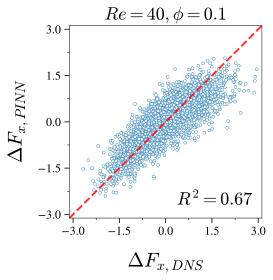

In [72]:
%reset -f array
%matplotlib inline

# free up memory from previous plots_________________
plt.close('all')
plt.clf()

# load dataset _______________________________________
Re = '40'
phi = '0.1'

num_p_incl = 29
N_neurons = 15
epochs = 2000
lr = 1.2e-2
verbose = 0
batch_size = 100

coord, title = 'F_x', r'$ Re = ' + f'{Re},' + r' \phi = ' + f'{phi} $'

dataset = pd.read_csv(f'./dataset/Re{Re}_phi{phi.replace(".","")}',
                        header=None, delim_whitespace=True).values

# dataset = data_augment(dataset, 10)

X_in = dataset[:, :-6]
Y_in = dataset[:, [-3]]
Y_in -= Y_in.mean()

kf = KFold(n_splits=5, shuffle=True)
train_scores = []
test_scores = []

X_test_plot = np.zeros((0, X_in.shape[1]))
Y_test_plot = np.zeros((0, 1))
Y_pred_test_plot = np.zeros((0, 1))

from IPython.display import display, Math
display(Math('$ \Delta ' + coord + ' $'))
display(Math(title))

print('Input shape:', X_in.shape)
print(f'# of neighbors in the dataset = {int((X_in.shape[1] - 3) / 3) + 1}')
print(f'# of neighbors used for training = {num_p_incl}')
print('________________________________________')

q = -1
# Train-Test split for K-fold cross-validation _______________________________________
for train_index, test_index in kf.split(X_in):
    
    q += 1
    # if q == 1: break

    X_train_list = []
    X_test_list = []
    p_input_list = []
    p_out_list = []
    
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    V_in_train = X_train[:, -3:]
    V_in_test = X_test[:, -3:]
    
    # Training =======================================
    glorot = tf.keras.initializers.GlorotNormal()
    
    # Custom neural network _______________________________________
    p_shared_layer1 = Dense(N_neurons,
                            activation='tanh',
                            kernel_initializer=glorot,
                            name='p_shared1')
    
    p_shared_layer2 = Dense(N_neurons,
                            activation='tanh',
                            kernel_initializer=glorot,
                            name='p_shared2')
    
    def summation(p_tensor):
        '''
        Each individual neighbor contribution to drag is
        always directed along the x-direction.
        '''
        # Drag _______________________________________
        return tf.reduce_sum(p_tensor, axis=1, keepdims=True)
    #_______________________________________________________________________________

    for p in range(0, num_p_incl):
        X_train_list.append( X_train[:, 3*p:3*p+3] )
        p_input_list.append( Input(shape=3, name=f'p_r{p}') )
        p_out_list.append( (p_shared_layer2(p_shared_layer1(p_input_list[p]))) )
    
    V_input = Input(shape=V_in_train.shape[1], name='V_in')

    concat = Concatenate()(
        [Lambda(summation, name=f'summation{j}')(p_out_list[j])\
        for j in range(num_p_incl)] + [V_input])

    nonneg = tf.keras.constraints.NonNeg()

    output_layer = Dense(1,
                        activation='linear',
                        kernel_constraint=nonneg,
                        name='out_x',
                        use_bias=False
                        )(concat)
    
    # Neural net fitting _______________________________________

    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / (SS_tot + K.epsilon())
    
    model = Model(inputs=p_input_list + [V_input],
                outputs=output_layer)

    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    mycallback = EarlyStopping(monitor='val_loss', patience=50)

    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)
    
    history = model.fit(
                        X_train_list + [V_in_train],
                        Y_train,

                        validation_split=0.2,
                        shuffle=True,
                        epochs=epochs,
                        verbose=verbose,
                        batch_size=batch_size,
                        callbacks=[mycallback],
                        )
    
    Y_pred = model.predict(X_train_list + [V_in_train])
    
    print(f'Training R^2\t= {r2_score(Y_train, Y_pred):.2f}')
    train_scores.append(r2_score(Y_train, Y_pred))
    
    # Testing =======================================
    for p in range(0, num_p_incl):
        X_test_list.append( X_test[:, 3*p:3*p+3] )

    Y_pred_test = model.predict(X_test_list + [V_in_test])
    
    print(f'Test R^2\t= {r2_score(Y_test, Y_pred_test):.2f}\n')
    test_scores.append(r2_score(Y_test, Y_pred_test))
    
    # dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))

print('========================================\nOverall performance:')
print(f'<Training R^2> = {np.mean(train_scores):.2f}')
print(f'<Test R^2> = {np.mean(test_scores):.2f}')

# model.save(f'model_{coord}_Re{Re}_phi{phi.replace(".","")}.h5')

plot_regression(
    D_in=Y_test_plot,
    D_pred=Y_pred_test_plot,
    coord=coord, title=title,
    save_fig=False, img_name=f'./plots/corr_{coord}_Re{Re}_phi{phi.replace(".","")}.pdf')

print(f'\nTotal number of model parameters: {model.count_params()}\n')
# plot_NN(model, n_rot=10)

Max neighbor distance = 3.867


<Figure size 432x288 with 0 Axes>

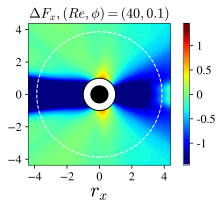

In [47]:
plot_NN(model, n_rot=50)

In [43]:
plot_model(model, rankdir='TB', dpi=100, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## PINN for Lift/Torque

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Input shape: (3000, 90)
# of neighbors in the dataset = 30
# of neighbors used for training = 6
________________________________________
Training R^2	= 0.77
Test R^2	= 0.74

Training R^2	= 0.77
Test R^2	= 0.73

Training R^2	= 0.77
Test R^2	= 0.76

Training R^2	= 0.77
Test R^2	= 0.76

Training R^2	= 0.77
Test R^2	= 0.74

Overall performance:
<Training R^2> = 0.77
<Test R^2> = 0.75


Total number of model parameters: 318



<Figure size 432x288 with 0 Axes>

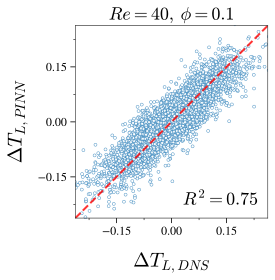

In [67]:
%reset -f array
%matplotlib inline

# free up memory from previous plots_________________
plt.close('all')
plt.clf()

# load dataset _______________________________________
Re = '40'
phi = '0.1'

num_p_incl = 6
N_neurons = 15
epochs = 2000
lr = 9e-3
verbose = 0
batch_size = 100

coord, title = r'T_L', r'$ Re = ' + f'{Re}, \:' + r' \phi = ' + f'{phi} $'

dataset = pd.read_csv(f'./dataset/Re{Re}_phi{phi.replace(".","")}',
                        header=None, delim_whitespace=True).values

# dataset = data_augment(dataset, 10)

X_in = dataset[:, :-6]

if coord == 'F_L':
    Y_in = dataset[:, -2:] # Lift
if coord == 'T_L':
    Y_in = dataset[:, -5:-3] # Torque

Y_in -= Y_in.mean(axis=0)

kf = KFold(n_splits=5, shuffle=True)
train_scores = []
test_scores = []

X_test_plot = np.zeros((0, X_in.shape[1]))
Y_test_plot = np.zeros((0, Y_in.shape[1]))
Y_pred_test_plot = np.zeros((0, Y_in.shape[1]))

from IPython.display import display, Math
display(Math('$ \Delta ' + coord + ' $'))
display(Math(title))

print('Input shape:', X_in.shape)
print(f'# of neighbors in the dataset = {int((X_in.shape[1] - 3) / 3) + 1}')
print(f'# of neighbors used for training = {num_p_incl}')
print('________________________________________')

q = -1
# Train-Test split for K-fold cross-validation _______________________________________
for train_index, test_index in kf.split(X_in):
    
    q += 1
#     if q == 1: break

    X_train_list = []
    X_test_list = []
    p_input_list = []
    p_out_list = []
    
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
    
    # Training =======================================
    
    glorot = tf.keras.initializers.GlorotNormal()

    # Custom neural network _______________________________________
    p_shared_layer1 = Dense(N_neurons,
                            activation='tanh',
                            kernel_initializer=glorot,
                            name='p_shared1')
    
    p_shared_layer2 = Dense(N_neurons,
                            activation='tanh',
                            kernel_initializer=glorot,
                            name='p_shared2')
    
    '''
    The two functions below first create the ctrbution of each neighbor to the force/torque
    of the test particle in vector form, then project this vector onto the desired
    direction for the computation of the force/torque component in that particular direction.
    '''
    def project_y(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))

        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)

        # Lift _______________________________________
        if coord == 'F_L':
            e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)

        # Torque _______________________________________
        if coord == 'T_L':
            e_ctrb = tf.linalg.cross(e_x, e_r)

        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_y ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    def project_z(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))
        
        e_r = pos_vec / tf.linalg.norm(pos_vec, axis=1, keepdims=True)

        # Lift _______________________________________
        if coord == 'F_L':
            e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)

        # Torque _______________________________________
        if coord == 'T_L':
            e_ctrb = tf.linalg.cross(e_x, e_r)

        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_z ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    for p in range(0, num_p_incl):
        X_train_list.append( X_train[:, 3*p:3*p+3] )
        p_input_list.append( Input(shape=3, name=f'p_r{p}') )
        p_out_list.append( (p_shared_layer2(p_shared_layer1(p_input_list[p]))) )
    
    V_in_train = X_train[:, -3:]
    V_input = Input(shape=V_in_train.shape[1], name='V')

    ctrb_y = Concatenate()(
        [Lambda(project_y, name=f'proj_y{j}')([p_input_list[j], p_out_list[j]])\
        for j in range(num_p_incl)] + [V_input])
    ctrb_z = Concatenate()(
        [Lambda(project_z, name=f'proj_z{j}')([p_input_list[j], p_out_list[j]])\
        for j in range(num_p_incl)] + [V_input])
    
    nonneg = tf.keras.constraints.NonNeg()

    out_y = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                name='out_y', use_bias=False)(ctrb_y)
    out_z = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                name='out_z', use_bias=False)(ctrb_z)
    
    out = Concatenate(name='out_concat_layer')([out_y, out_z])
    
    # Neural net fitting _______________________________________
    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / (SS_tot + K.epsilon())
    
    model = Model(inputs=p_input_list + [V_input],
                outputs=out)

    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    mycallback = EarlyStopping(monitor='val_loss', patience=50)

    model.compile(loss='mse', optimizer=myoptimizer, metrics=R2)
    
    history = model.fit(
                        X_train_list + [V_in_train],
                        Y_train,

                        validation_split=0.2,
                        shuffle=True,
                        epochs=epochs,
                        verbose=verbose,
                        batch_size=batch_size,
                        callbacks=[mycallback],
                        )
    
    Y_pred = model.predict(X_train_list + [V_in_train])
    
    print(f'Training R^2\t= {r2_score(Y_train, Y_pred):.2f}')
    # print('Training R^2\t=', r2_score(Y_train, Y_pred, multioutput="raw_values"))
    train_scores.append(r2_score(Y_train, Y_pred, multioutput='raw_values'))
    
    # Testing =======================================
    for p in range(0, num_p_incl):
        X_test_list.append( X_test[:, 3*p:3*p+3] )

    V_in_test = X_test[:, -3:]
    
    Y_pred_test = model.predict(X_test_list + [V_in_test])

    print(f'Test R^2\t= {r2_score(Y_test, Y_pred_test):.2f}\n')
    # print('Test R^2\t=', r2_score(Y_test, Y_pred_test, multioutput="raw_values"), '\n')
    test_scores.append(r2_score(Y_test, Y_pred_test))
    
    # dataset for plotting all the tests together
    X_test_plot = np.vstack((X_test_plot, X_test))
    Y_test_plot = np.vstack((Y_test_plot, Y_test))
    Y_pred_test_plot = np.vstack((Y_pred_test_plot, Y_pred_test))

print('========================================\nOverall performance:')
print(f'<Training R^2> = {np.mean(train_scores):.2f}')
print(f'<Test R^2> = {np.mean(test_scores):.2f}\n')

# model.save(f'./models/model_{coord}_Re{Re}_phi{phi.replace(".","")}.h5')

plot_regression(
    D_in=Y_test_plot,
    D_pred=Y_pred_test_plot,
    coord=coord, title=title,
    save_fig=False, img_name=f'./plots/corr_{coord}_Re{Re}_phi{phi.replace(".","")}.pdf')

print(f'\nTotal number of model parameters: {model.count_params()}\n')
# plot_NN(model, n_rot=10)

In [ ]:
plot_NN(model, n_rot=50)

## Plots

### NN weights associated with each neighbor

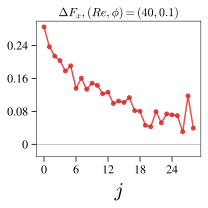

In [61]:
if coord == 'F_x':
    w = model.get_layer('out_x').get_weights()[0]  # Drag
if coord in ['F_L', 'T_L']:
    w = model.get_layer('out_y').get_weights()[0] # Lift or torque

fig, ax1 = plt.subplots(figsize=(3, 3), tight_layout=True)

ax1.plot(w[:-3],
         linestyle='-',
         marker='o',
         markersize=4,
         color='tab:red',
         linewidth=1.5,
         alpha=0.8,
         )

ax1.axhline(y=0, color='black', linewidth=0.5, alpha=0.4, linestyle='-')

# ax1.legend(fontsize=14, borderpad=0.2, frameon=False, loc='lower right',)

ax1.set_xlabel('$ j $', labelpad=7)
# ax1.set_ylabel('$ w_j $', labelpad=10)
        
# ax1.set_xlim((-0.05, 30))
ax1.set_ylim(bottom=-0.03)

# ax1.set_xticks(range(1, 20, 1))
# ax1.set_yticks(np.arange(0, 0.8, 0.1))

ax1.set_title(r'$ \Delta ' + f'{coord}, ' + r'(Re, \phi) = (' + f'{Re}, {phi})' + r'$',
                  fontsize=12, pad=5)

# ticks _____________________
from matplotlib.ticker import (AutoMinorLocator, MaxNLocator, FormatStrFormatter)

ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

ax1.xaxis.set_major_locator(MaxNLocator(6))
# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))

ax1.yaxis.set_major_locator(MaxNLocator(5))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(which='major', length=5)
ax1.tick_params(which='minor', length=3)

# Set the font name for axis tick labels _____________________
for tick in ax1.get_xticklabels():
    tick.set_fontname('STIXGeneral')
for tick in ax1.get_yticklabels():
    tick.set_fontname('STIXGeneral')

# fig.savefig(f'./plots/w_j_{coord}_Re{Re}_phi{phi.replace(".","")}.pdf', bbox_inches='tight')

### Performance comparisons

#### Data

In [63]:
# dF_x, Re = 40, phi = 0.1
FCNN_train = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.23, 0.33, 0.38, 0.36, 0.36, 0.34, 0.28,
                      0.28, 0.28, 0.28, 0.31, 0.30, 0.31, 0.34,
                      0.35, 0.36, 0.38, 0.38, 0.40, 0.41]}
FCNN_test = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.20, 0.25, 0.23, 0.18, 0.13, 0.07, -0.02,
                      -0.04, -0.1, -0.19, -0.22, -0.26, -0.22, -0.23,
                      -0.34, -0.36, -0.40, -0.38, -0.44, -0.48]}

PINN_train = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.23, 0.33, 0.40, 0.42, 0.50, 0.52, 0.55,
                      0.57, 0.58, 0.60, 0.62, 0.62, 0.63, 0.65,
                      0.65, 0.66, 0.67, 0.67, 0.69, 0.70]}
PINN_test = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.18, 0.29, 0.35, 0.33, 0.44, 0.47, 0.51,
                      0.52, 0.54, 0.56, 0.58, 0.57, 0.59, 0.61,
                      0.62, 0.62, 0.63, 0.64, 0.64, 0.65]}

In [64]:
# dF_L, Re = 40, phi = 0.2
FCNN_train = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.31, 0.43, 0.48, 0.48, 0.48, 0.48, 0.48,
                      0.47, 0.47, 0.45, 0.45, 0.41, 0.41, 0.41, 0.41,
                      0.40, 0.42, 0.42, 0.43, 0.43]}
FCNN_test = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.28, 0.39, 0.41, 0.40, 0.40, 0.37, 0.37,
                      0.34, 0.32, 0.29, 0.26, 0.23, 0.22, 0.18, 0.17,
                      0.14, 0.13, 0.11, 0.10, 0.06]}

PINN_train = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.30, 0.45, 0.53, 0.58, 0.60, 0.62, 0.62,
                      0.64, 0.64, 0.64, 0.65, 0.64, 0.65, 0.64, 0.66,
                      0.65, 0.65, 0.65, 0.64, 0.66]}
PINN_test = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.28, 0.43, 0.51, 0.56, 0.58, 0.59, 0.61,
                      0.62, 0.62, 0.62, 0.63, 0.62, 0.63, 0.62, 0.64,
                      0.64, 0.63, 0.63, 0.63, 0.65]}

In [65]:
# dT_L, Re = 40, phi = 0.4
FCNN_train = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.28, 0.48, 0.57, 0.61, 0.62, 0.62, 0.61,
                      0.62, 0.63, 0.62, 0.62, 0.63, 0.63, 0.63, 0.64,
                      0.64, 0.64, 0.65, 0.65, 0.65]}
FCNN_test = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.26, 0.44, 0.52, 0.55, 0.55, 0.54, 0.53,
                      0.53, 0.51, 0.51, 0.50, 0.48, 0.49, 0.48, 0.44,
                      0.45, 0.42, 0.43, 0.42, 0.40]}

PINN_train = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.26, 0.44, 0.55, 0.61, 0.67, 0.69, 0.70,
                      0.70, 0.70, 0.71, 0.70, 0.70, 0.71, 0.70, 0.70,
                      0.69, 0.71, 0.68, 0.71, 0.69]}
PINN_test = {'M': [i for i in range(0, 21)],
              'Rsq': [0, 0.25, 0.43, 0.55, 0.60, 0.66, 0.68, 0.69,
                      0.68, 0.69, 0.70, 0.68, 0.68, 0.69, 0.69, 0.69,
                      0.68, 0.69, 0.66, 0.70, 0.67]}

#### Plots

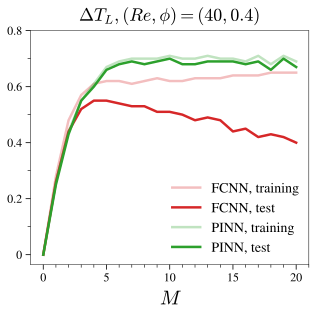

In [66]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(4.5, 4.5), tight_layout=True)

lw = 2.5
ms = 0

ax.plot(FCNN_train['M'], FCNN_train['Rsq'],
         linestyle='-',
         marker='o',
         markersize=ms,
         color='tab:red',
         linewidth=lw,
         alpha=0.3,
         label='FCNN, training',)

ax.plot(FCNN_test['M'], FCNN_test['Rsq'],
         linestyle='-',
         marker='s',
         markersize=ms,
         color='tab:red',
         linewidth=lw,
         alpha=1,
         label='FCNN, test',)

ax.plot(PINN_train['M'], PINN_train['Rsq'],
         linestyle='-',
         marker='o',
         markersize=ms,
         color='tab:green',
         linewidth=lw,
         alpha=0.3,
         label='PINN, training',)

ax.plot(PINN_test['M'], PINN_test['Rsq'],
         linestyle='-',
         marker='s',
         markersize=ms,
         color='tab:green',
         linewidth=lw,
         alpha=1,
         label='PINN, test',)

# ax.axhline(y=0, color='black', linewidth=1, alpha=0.5, linestyle='--')

ax.legend(fontsize=14, borderpad=0.2, frameon=False, loc='lower right',)

ax.set_xlabel('$ M $', labelpad=7)
# ax.set_ylabel('$ R^2 $', labelpad=0)
        
# ax.set_xlim((0, 30))
ax.set_ylim(top=0.8)

ax.set_xticks(range(1, 20, 1))
# ax.set_yticks(np.arange(0, 0.8, 0.1))

ax.set_title('$ \Delta T_L, (Re, \phi) = (40, 0.4) $', pad=10)

# ticks _____________________
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator, FormatStrFormatter)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)

# Set the font name for axis tick labels _____________________
for tick in ax.get_xticklabels():
    tick.set_fontname('STIXGeneral')
for tick in ax.get_yticklabels():
    tick.set_fontname('STIXGeneral')

# fig.savefig('./plots/Rsq_M_dT_L_Re40_phi04.pdf', bbox_inches='tight')